## Задание, оцениваемое сокурсниками: Прогнозирование уровня средней заработной платы в России

Известны данные о среднемесячных уровнях заработной платы в России с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

In [1]:
import pandas as pd

dataset = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
dataset.head()

WAG_C_M
month              
1993-01-01     15.3
1993-02-01     19.1
1993-03-01     23.6
1993-04-01     30.6
1993-05-01     37.5

### Визуальный анализ ряда
На графике виден хорошо выраженный повышающийся тренд, который можно описать нелинейной функцией. Достаточно сильно выражена годовая сезонность. Кроме того, у этого ряда нестационарна дисперсия - размах ряда в начале сильно отличается от размаха ближе к концу ряда.

Populating the interactive namespace from numpy and matplotlib


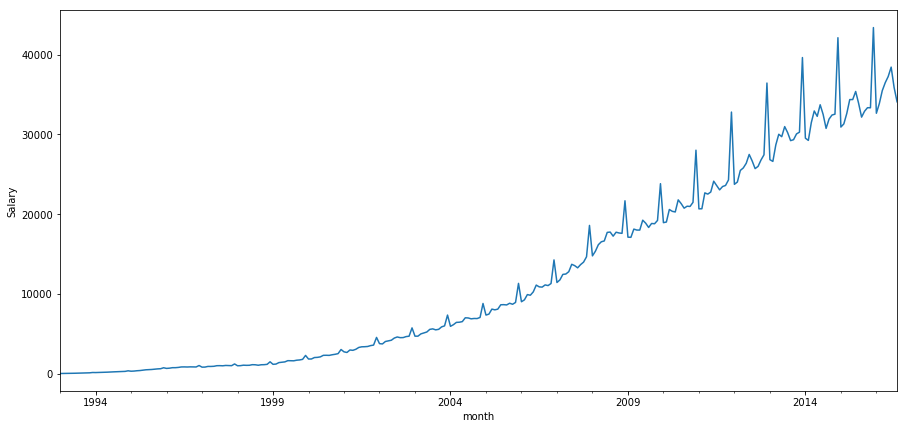

In [2]:
%pylab inline
import matplotlib.pyplot as plt

plt.figure(figsize(15,7))
dataset.WAG_C_M.plot()
plt.ylabel('Salary')
pylab.show()

### Стабилизация дисперсии (при необходимости)
Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


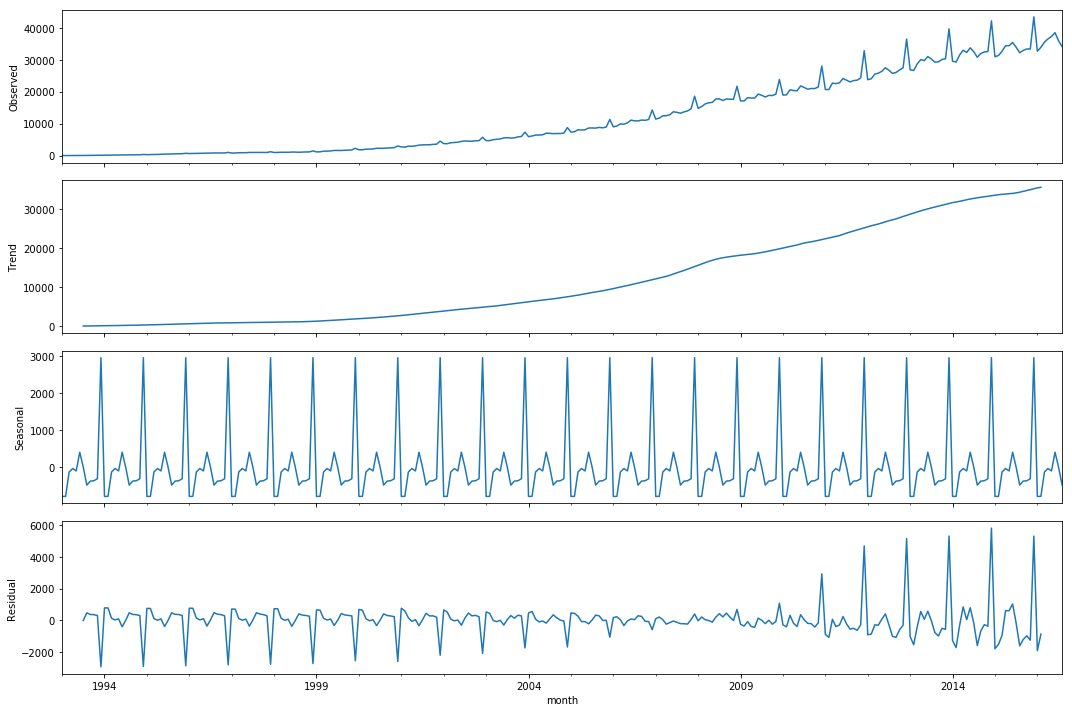

In [3]:
import statsmodels.api as sm

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(dataset.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(dataset.WAG_C_M)[1])

Критерий Дики-Фуллера для этого ряда значительно больше 0.05, следовательно, гипотезу о нестационарности ряда отвергнуть не удается.

#### STL-декомпозиция ряда:
1. На верхнем из четырех графиков находится исходный ряд.
2. Тренд, как было уже замечено ранее постоянно повышается, причем нелинейно
3. Сезонный профиль достаточно хорошо выражен
4. Остатки далеко не похожи на случайный шум, в них остаётся большая часть структуры, которая не была учтена в регрессионной модели.

Ряд нельзя считать стационарным, поэтому сделаем преобразование, стабилизирующее дисперсию — преобразование Бокса-Кокса.

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


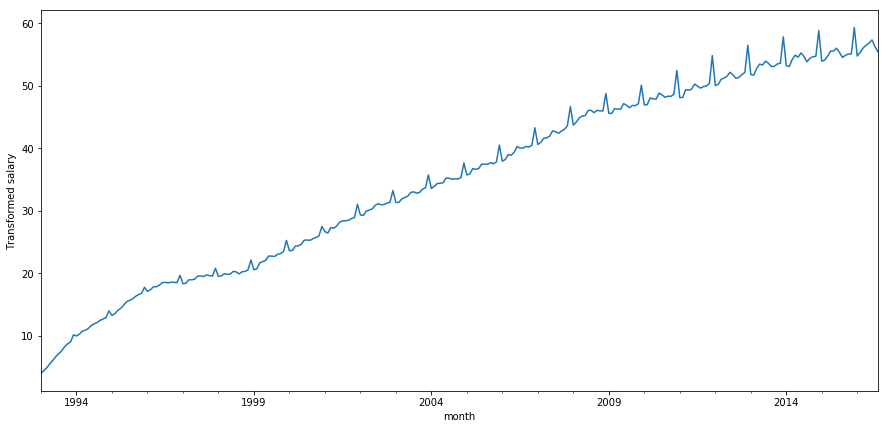

In [4]:
import numpy as np
from scipy import stats

dataset['ln_WAG_C_M'], lmbda = stats.boxcox(dataset['WAG_C_M'])
plt.figure(figsize(15,7))
dataset.ln_WAG_C_M.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(dataset['ln_WAG_C_M'])[1])

Критерий Дики-Фуллера на этом ряде даёт достигаемый уровень значимости примерно 0,7. То есть нулевая гипотеза нестационарности не отвергается и визуально в данных виден тренд.

### Выбор порядка дифференцирования
Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


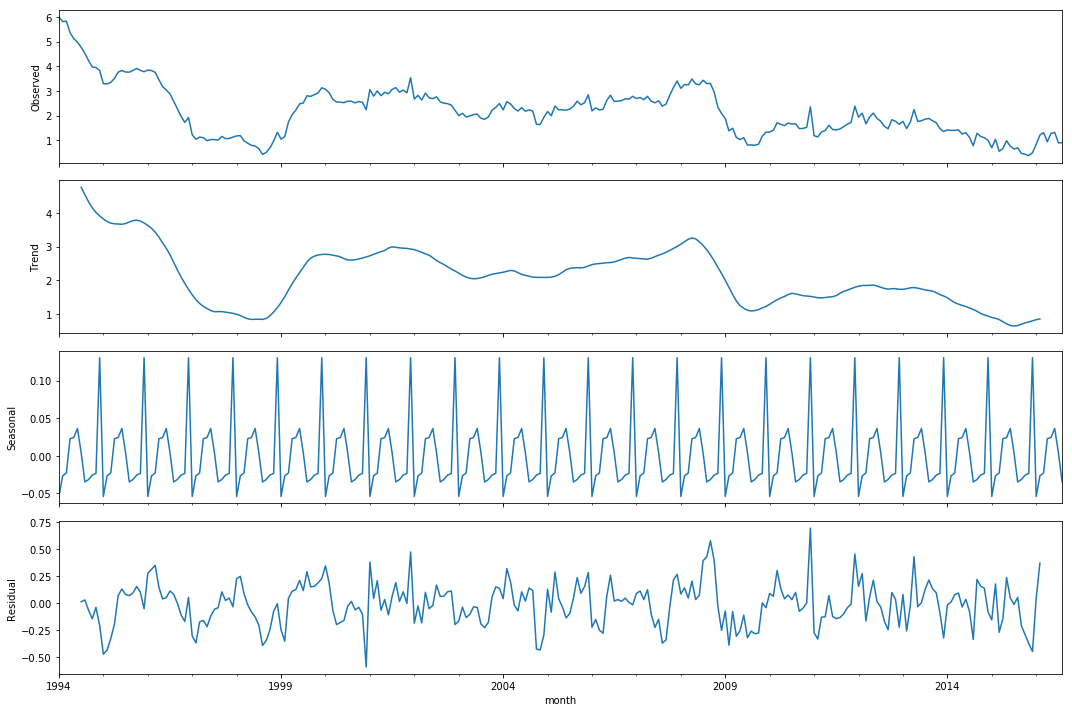

In [5]:
dataset['ln_WAG_C_M_diff'] = dataset.ln_WAG_C_M - dataset.ln_WAG_C_M.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(dataset.ln_WAG_C_M_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(dataset.ln_WAG_C_M_diff[12:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — какой-то тренд в данных всё же присутствует.

После обычного дифференцирования уже трудно сказать о каком-либо тренде. Критерий Дики-Фуллера уверенно подтверждает это.

Критерий Дики-Фуллера: p=0.000000


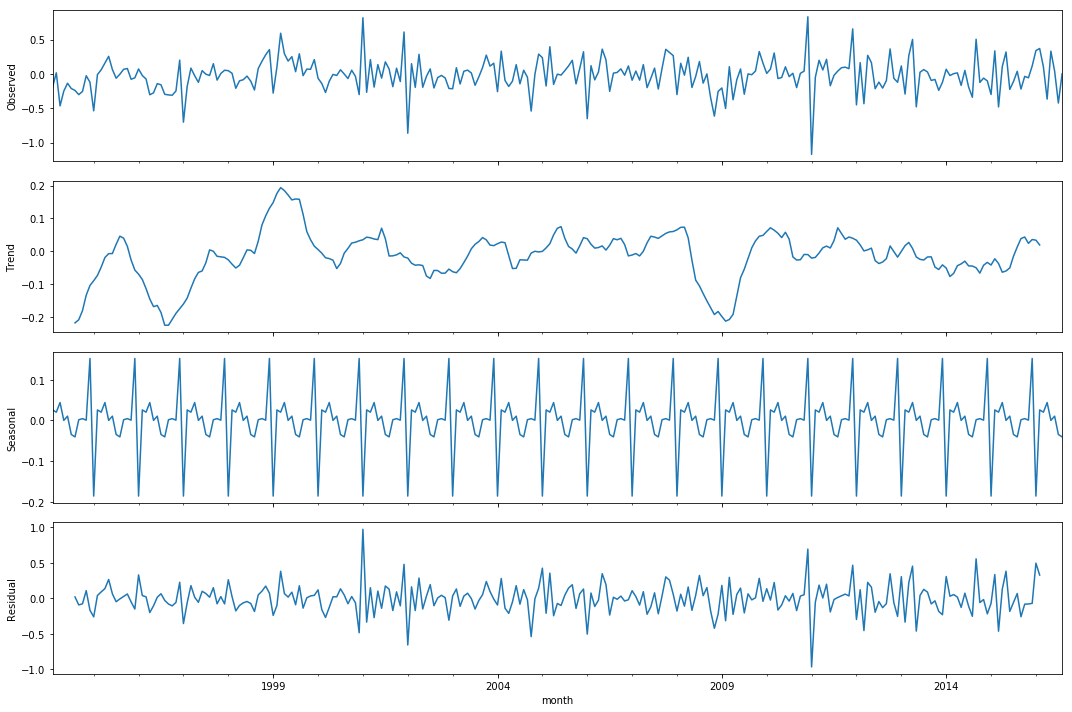

In [6]:
dataset['ln_WAG_C_M_diff2'] = dataset.ln_WAG_C_M_diff - dataset.ln_WAG_C_M_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(dataset.ln_WAG_C_M_diff2[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(dataset.ln_WAG_C_M_diff2[13:])[1])

### Выбор начальных приближений для p,q,P,Q
Посмотрим на ACF и PACF полученного ряда:

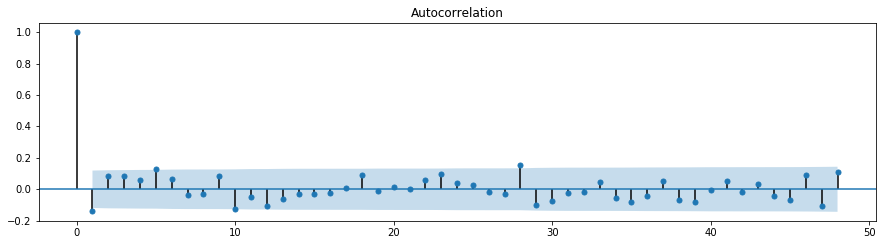

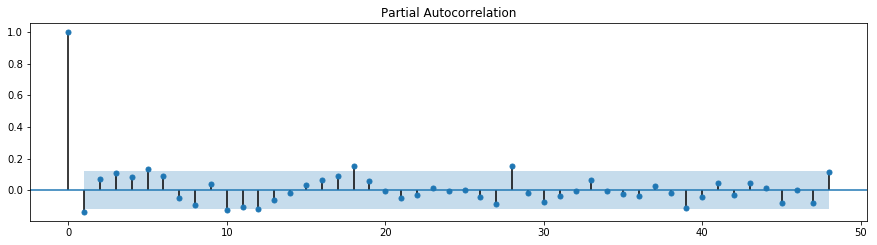

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(dataset.ln_WAG_C_M_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(dataset.ln_WAG_C_M_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

- Q = 0: Максимальный сезонный лаг, значимо отличающийся от нуля, это лаг 0.

- q = 10: Что касается q — здесь максимальный значащий несезонный лаг на графике автокорреляции = 28. Так как это число слишком велико, для q начальное приближение мы будем брать равным 10.

- P = 1: Перейдём к начальному приближению для P. На частично автокорреляционной функции единственный сезонный лаг, значимо отличающийся от нуля — это лаг 12. Значит P мы возьмём равным 1.

- p = 10: Максимальный значащий несезонный лаг на графике частичной автокорреляции меньший P - это 10

In [10]:
ps = range(0, 11)
d=1
qs = range(0, 11)
Ps = range(0, 2)
D=1
Qs = range(0, 1)

### Обучение и сравнение моделей-кандидатов, выбор победителя

In [11]:
from itertools import product

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

242

In [12]:
%%time
import warnings

results = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(dataset.ln_WAG_C_M, order=(param[0], d, param[1]), \
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print 'wrong parameters:', param
        continue
    except LinAlgError:
        print 'wrong parameters:', param
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (1, 2, 1, 0)
wrong parameters: (1, 10, 0, 0)
wrong parameters: (1, 10, 1, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (2, 3, 1, 0)
wrong parameters: (2, 10, 0, 0)
wrong parameters: (2, 10, 1, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 3, 1, 0)
wrong parameters: (3, 4, 0, 0)
wrong parameters: (3, 4, 1, 0)
wrong parameters: (3, 10, 0, 0)
wrong parameters: (3, 10, 1, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 3, 1, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (4, 4, 1, 0)
wrong parameters: (4, 10, 0, 0)
wrong parameters: (4, 10, 1, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 2, 1, 0)
wrong parameters: (5, 3, 0, 0)


In [13]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
86   (5, 5, 1, 0) -25.850000
102  (6, 5, 1, 0) -24.060065
85   (5, 5, 0, 0) -23.101210
62   (3, 7, 1, 0) -21.254435
101  (6, 5, 0, 0) -21.215156


Лучшая модель:

In [14]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                         ln_WAG_C_M   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, 0, 12)   Log Likelihood                  24.925
Date:                            Sun, 07 Jan 2018   AIC                            -25.850
Time:                                    12:58:36   BIC                             17.938
Sample:                                01-01-1993   HQIC                            -8.295
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0048     11.052      0.000      1.000     -21.656      21.665
ar.L2          0.0073      7.325   

Ее остатки:

Критерий Стьюдента: p=0.170317
Критерий Дики-Фуллера: p=0.000000


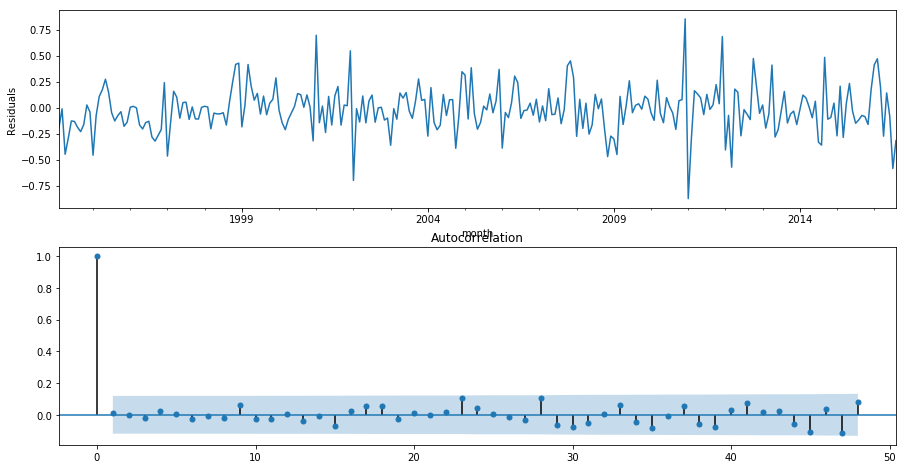

In [15]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки:
1. несмещены - подтверждается критерием Стьюдента)
2. стационарны - подтверждается критерием Дики-Фуллера и визуально
3. неавтокоррелированы - подтверждается критерием Льюинга-Бокса и коррелограммой

Посмотрим, насколько хорошо модель описывает данные:

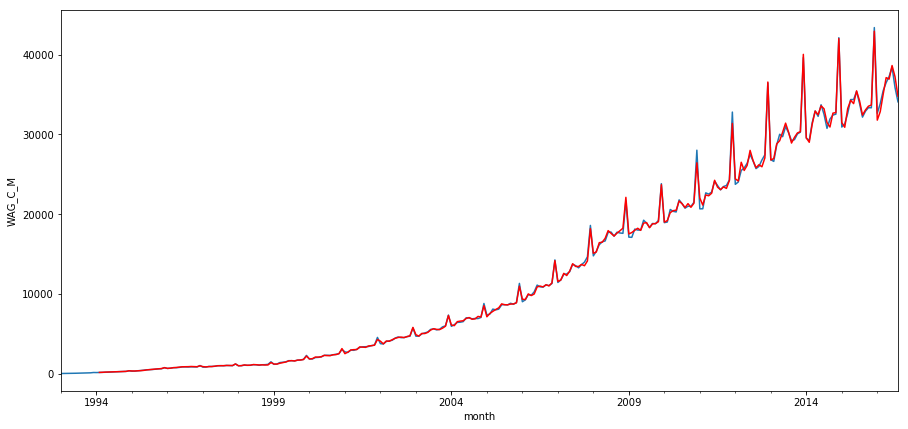

In [16]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1) / lmbda))

dataset['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
dataset.WAG_C_M.plot()
dataset.model[13:].plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()

### Прогнозирование с помощью финальной модели

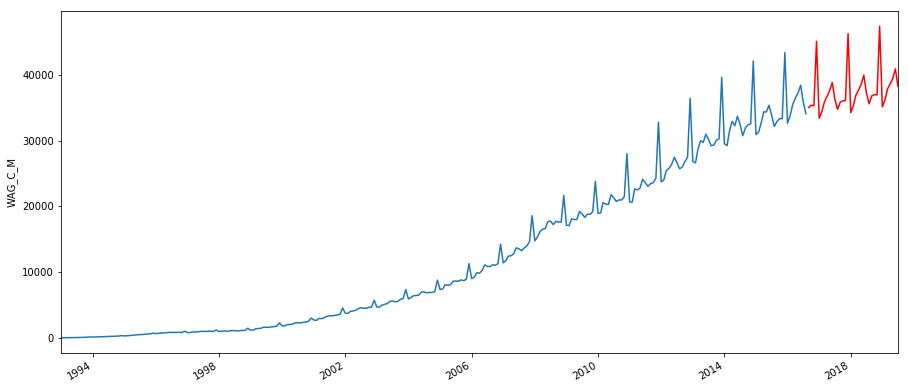

In [20]:
dataset2 = dataset[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= dataset2.columns)
dataset2 = pd.concat([dataset2, future])
dataset2['forecast'] = invboxcox(best_model.predict(start=284, end=319), lmbda)

plt.figure(figsize(15,7))
dataset2.WAG_C_M.plot()
dataset2.forecast.plot(color='r')
plt.ylabel('WAG_C_M')
pylab.show()